# Final Project

## Objective
- Mampu memahami penggunaan LSTM untuk prediksi instrument keuangan
- Mampu menghasilkan prediksi nilai suatu instrument keuangan pada data test.
- Mampu menghasilkan prediksi nilai suatu instrument keuangan pada waktu berikutnya.
- Mampu menganalisis dan menjelaskan layer yang dibuat.


## i. Perkenalan

Kelompok 2

Anggota : 
- Anugrah Yoga Pratama
- M Naufal Indriatmoko
- Tandya Anggergian

Dataset : Crude Oil (CL=F)

## ii. Import Libraries

Import pustaka.

In [29]:
# Import Modul
import math
import pickle 
import pandas_datareader as web
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.graph_objects as go
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
# Menggunakan style plot seaborn darkgrid
plt.style.use('seaborn-darkgrid')

## iii. Data Loading

Upgrade pandas dan pandas-datareader.

In [ ]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Deklarasikan nama quote instrumen keuangan.

In [30]:
quote = 'CL=F'

Membuat variabel tanggal terbaru hari ini.

In [32]:
# today = date.today()
# print("Today's date:", today)

today = '2022-06-06'

Membaca data dari yahoo dengan tanggal awal dan akhir yang ditentukan.

In [33]:
df = web.DataReader(quote,
                    data_source='yahoo',
                    start='2002-01-01',
                    end=today)

Overview data.

In [134]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2002-01-02,21.049999,19.850000,20.000000,21.010000,69560.0,21.010000
2002-01-03,21.100000,20.150000,20.780001,20.370001,64010.0,20.370001
2002-01-04,21.700001,20.400000,20.850000,21.620001,84832.0,21.620001
2002-01-07,22.000000,21.200001,21.500000,21.480000,64080.0,21.480000
2002-01-08,21.500000,21.000000,21.200001,21.250000,59541.0,21.250000


Cek bentuk data.

In [35]:
df.shape

(5134, 6)

Menampilkan data historikal harga penutupan emas.

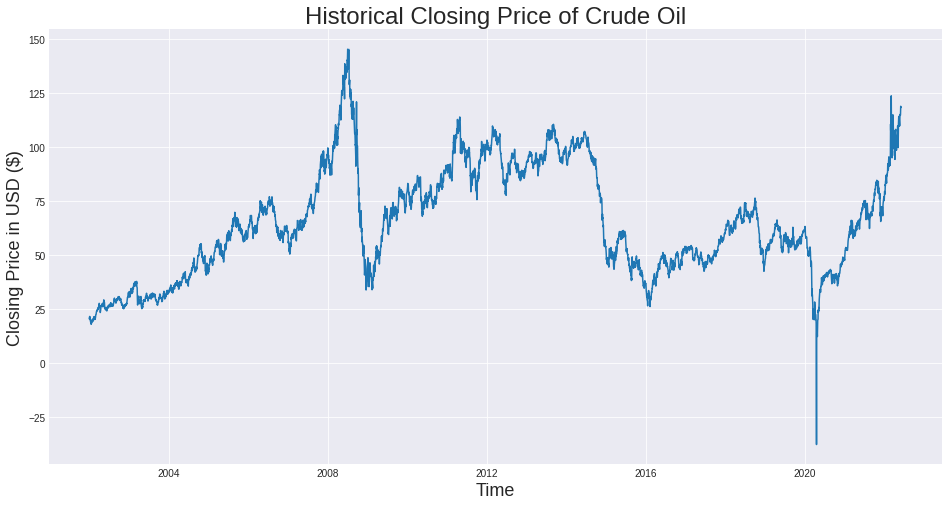

In [135]:
plt.figure(figsize=(16,8))
plt.title(f'Historical Closing Price of Crude Oil', fontsize=24)
plt.plot(df['Close'])
plt.xlabel('Time', fontsize=18)
plt.ylabel('Closing Price in USD ($)', fontsize=18)
plt.show()

In [136]:
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'], high=df['High'],
                low=df['Low'], close=df['Close'])
                     ])

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

## iv. Exploratory Data Analysis (EDA)

In [137]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2002-01-02,21.049999,19.850000,20.000000,21.010000,69560.0,21.010000
2002-01-03,21.100000,20.150000,20.780001,20.370001,64010.0,20.370001
2002-01-04,21.700001,20.400000,20.850000,21.620001,84832.0,21.620001
2002-01-07,22.000000,21.200001,21.500000,21.480000,64080.0,21.480000
2002-01-08,21.500000,21.000000,21.200001,21.250000,59541.0,21.250000


Cek ringkasan deskripsi data.

In [138]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,5134.000000,5134.000000,5134.000000,5134.000000,5.134000e+03,5134.000000
mean,66.185921,64.124768,65.185649,65.193360,3.189129e+05,65.193360
std,25.074654,24.588585,24.839920,24.858837,2.181228e+05,24.858837
min,13.690000,-40.320000,-14.000000,-37.630001,2.000000e+01,-37.630001
25%,47.549999,45.730000,46.682500,46.662499,1.314652e+05,46.662499
50%,62.570002,60.855000,61.790001,61.779999,2.769370e+05,61.779999
75%,86.285000,83.645000,85.089996,85.167500,4.260472e+05,85.167500
max,147.270004,143.220001,145.190002,145.289993,2.288230e+06,145.289993


Harga all time high terjadi pada tanggal 11-07-2008 pada harga tertinggi 147.

In [139]:
all_time_high = df.describe().loc['max']['High']
df[df['High'] == all_time_high]

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2008-07-11,147.270004,141.440002,141.800003,145.080002,334940.0,145.080002


Harga all time low terjadi pada tanggal 20-4-2020 pada harga terendah -40.32.

In [140]:
all_time_low = df.describe().loc['min']['Low']
df[df['Low'] == all_time_low]

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-04-20,17.85,-40.32,17.73,-37.630001,247947.0,-37.630001


Volume perdagangan/transaksi terbesar adalah sebagai berikut:

In [141]:
highest_vol = df.describe().loc['max']['Volume']
df[df['Volume'] == highest_vol]

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-04-21,13.86,-16.74,-14.0,10.01,2288230.0,10.01


Return gain tertinggi antara harga all time high dan all time low.

In [45]:
high_low_gain = df.describe().loc['max']['Close']/df.describe().loc['min']['Close']

print(f'Biggest Return Between Highest and Lowest Price : {(high_low_gain - 1)*100:.2f}%')

Biggest Return Between Highest and Lowest Price : -486.10%


## v. Data Preprocessing

Memilih hanya kolom `close`.

In [142]:
data = df.filter(['Close'])
data

,Close
Date,
2002-01-02,21.010000
2002-01-03,20.370001
2002-01-04,21.620001
2002-01-07,21.480000
2002-01-08,21.250000
...,...
2022-05-31,114.669998
2022-06-01,115.260002
2022-06-02,116.870003


Mengambil valuenya saja.

In [47]:
dataset = data.values

dataset

array([[ 21.01000023],
       [ 20.37000084],
       [ 21.62000084],
       ...,
       [116.87000275],
       [118.87000275],
       [118.30999756]])

Menghitung banyak data untuk training dengan proporsi training 0.8 dari total data.

In [48]:
#Split data into 0.8 for training and 0.2 for testing
training_data_len = math.ceil(len(dataset)*0.8)

training_data_len

4108

### Scaling data

Split data menjadi train dan test dengan jumlah yang telah dihitung sebelumnya 

In [49]:
train_data = dataset[:training_data_len]
test_data = dataset[training_data_len:]

train_data.shape, test_data.shape

((4108, 1), (1026, 1))

Scalling data menggunakan minmax scaler.

In [50]:
scaler = Pipeline([
                   ('scaler', MinMaxScaler())
])

scaler.fit(train_data)
train_scaled_data = scaler.transform(train_data)
test_scaled_data = scaler.transform(test_data)

In [51]:
# simpan scaler
with open("oil_scaler.pkl", "wb") as f:
  pickle.dump(scaler, f)

In [52]:
train_scaled_data

array([[0.02364679],
       [0.01861891],
       [0.02843901],
       ...,
       [0.40113128],
       [0.41747193],
       [0.41920028]])

In [53]:
test_scaled_data

array([[0.41401524],
       [0.41605784],
       [0.41880745],
       ...,
       [0.77673036],
       [0.79244252],
       [0.78804307]])

### Data Training Preparation

Menyiapkan fitur dan label untuk data training. 

* Fitur x adalah data harga yang dipilih sebanyak n_days.
$$ x_{t-1},  x_{t-2},  x_{t-3}, ..., x_{t-n}$$
* Label y adalah data harga yang merupakan kombinasi linier dari sejumlah n_days fitur pada data sebelumnya.
$$y=x_t=w_1 x_{t-1} + w_2 x_{t-2} + w_3 x_{t-3} + ... + w_n x_{t-n}$$

In [54]:
x_train = [] # Buat list kosong u/ menampung data
y_train = []
n_days = 40

for i in range(n_days, len(train_data)):
  # Data awal hingga n_days data ke depan menjadi x_train
  x_train.append(train_scaled_data[i-n_days:i, 0])
  # Data ke n_days menjadi y_train
  y_train.append(train_scaled_data[i, 0])
  # Cek data pertama untuk fitur dan label 
  if i <=n_days:
    print(x_train)
    print(y_train)

[array([0.02364679, 0.01861891, 0.02843901, 0.02733914, 0.02553225,
       0.01712625, 0.01869746, 0.01319821, 0.0069919 , 0.00707047,
       0.00675623, 0.00031425, 0.        , 0.00471365, 0.01162699,
       0.01351245, 0.01571215, 0.01610495, 0.01233404, 0.00903449,
       0.01162699, 0.01885458, 0.01618351, 0.01610495, 0.01374813,
       0.01319821, 0.01767617, 0.02608217, 0.02160421, 0.02474664,
       0.02529656, 0.02749627, 0.02254695, 0.01751905, 0.02396103,
       0.02419672, 0.01901171, 0.02639642, 0.0258465 , 0.0302459 ])]
[0.034252500905949446]


Jumlah train_data = (jumlah `x_train` atau jumlah `y_train`) + `n_days`

In [55]:
x_test = [] # Buat list kosong u/ menampung data
y_test = []

for i in range(n_days, len(test_data)):
  # Data awal hingga n_days data ke depan menjadi x_test
  x_test.append(test_scaled_data[i-n_days:i, 0])
  # Data ke n_days menjadi y_test
  y_test.append(test_scaled_data[i, 0])

Mengubah menjadi numpy array.

In [56]:
# Mengubah data menjadi format numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

# Mengubah data menjadi format numpy array
x_test, y_test = np.array(x_test), np.array(y_test)

In [57]:
x_train.shape, x_test.shape

((4068, 40), (986, 40))

Mengubah dimensi data x menjadi 3D.

In [58]:
# Mengubah dimensi data train menjadi 3 dimensi karena LSTM butuh data berdimensi 3
x_train = np.reshape(x_train, 
    (x_train.shape[0],
    x_train.shape[1],
    1
))
x_train.shape

(4068, 40, 1)

In [59]:
# Mengubah x test menjadi 3 dimensi
x_test = np.reshape(x_test,
                    (x_test.shape[0],
                     x_test.shape[1],
                     1))

## vi. Model Definition

Membangun arsitektur time series dengan konfigurasi sebagai berikut:
1. Model Sequential
2. 2 Layer LSTM dengan jumlah masing-masing 50 dan input sebanyak n_days
3. Hidden layer sebanyak 25 neuron
4. Output layer sebanyak 1 neuron

In [143]:
# Architecture for Neural Network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(units=25))

model.add(Dense(1))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 40, 50)            10400     
                                                                 
 lstm_24 (LSTM)              (None, 50)                20200     
                                                                 
 dense_20 (Dense)            (None, 25)                1275      
                                                                 
 dense_21 (Dense)            (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


Compile model dengan optimizer adam dan loss mean squared error.

In [144]:
#Compile the architecture
model.compile(optimizer='adam', loss='mean_squared_error')

Membuat callback dengan early stopping ketika tidak mengalami optimisasi pada 4 epoch berikutnya dan dengan model checkpoint untuk menyimpan model terbaik.

In [145]:
# callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', mode= 'min', patience=4, verbose=1),
    ModelCheckpoint('ts_crudeoil.hdf5', monitor='val_loss', save_best_only=True)
]

## vii. Model Training

Training model pada data `x_train` terhadap `y_train` dengan 32 data batch dan epoch 100 kali.

In [146]:
history = model.fit(
    x=x_train, 
    y=y_train, 
    validation_data=(x_test, y_test),
    batch_size=32,
    callbacks=callbacks, 
    epochs=100
)

Epoch 1/100
128/128 [==============================] - 11s 58ms/step - loss: 0.0076 - val_loss: 0.0011
Epoch 2/100
128/128 [==============================] - 6s 49ms/step - loss: 6.8029e-04 - val_loss: 0.0012
Epoch 3/100
128/128 [==============================] - 6s 49ms/step - loss: 5.6783e-04 - val_loss: 9.7424e-04
Epoch 4/100
128/128 [==============================] - 6s 48ms/step - loss: 5.1105e-04 - val_loss: 9.2947e-04
Epoch 5/100
128/128 [==============================] - 6s 47ms/step - loss: 4.7420e-04 - val_loss: 0.0011
Epoch 6/100
128/128 [==============================] - 6s 48ms/step - loss: 4.4782e-04 - val_loss: 8.8409e-04
Epoch 7/100
128/128 [==============================] - 6s 49ms/step - loss: 4.6262e-04 - val_loss: 7.8797e-04
Epoch 8/100
128/128 [==============================] - 6s 47ms/step - loss: 3.9136e-04 - val_loss: 8.3262e-04
Epoch 9/100
128/128 [==============================] - 6s 46ms/step - loss: 3.9192e-04 - val_loss: 7.8046e-04
Epoch 10/100
128/128 [===

## viii. Model Evaluation

Membuat fungsi untuk menampilkan grafik loss terhadap epoch.

In [147]:
def loss(data_result):
    plt.figure(figsize=(7, 5))
    plt.plot(np.arange(1, 1+len(data_result)), data_result['loss'])
    plt.plot(np.arange(1, 1+len(data_result)), data_result['val_loss'])
    plt.title('Loss', fontsize=16, loc='center', color='maroon')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(labels=['loss', 'val_loss'])

    plt.tight_layout()
    plt.show()

Menampilkan grafik loss model

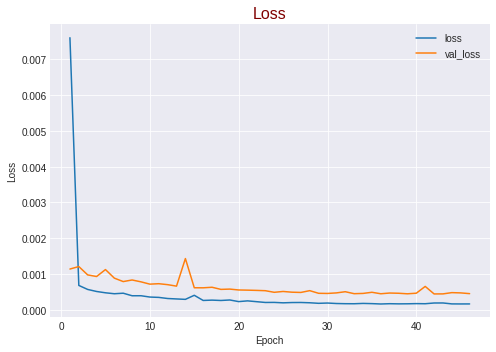

In [148]:
result = pd.DataFrame(history.history) # Membuat dataframe dari histori model
loss(result)

### Data Test Prediction

Melakukan prediksi terhadap `x_test` dengan model yang sudah ditraining.

In [149]:
predictions = model.predict(x_test)

# mengembalikan lagi ke nilai awal (tidak di scaling)
predictions = scaler.inverse_transform(predictions)

In [150]:
predictions.shape

(986, 1)

Unscalling data `y_test`.

In [151]:
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

Cek nilai Root Mean Square Error dan Mean Absolute Percentage Error.

In [152]:
rmse = (metrics.mean_squared_error(y_test_unscaled, predictions))**0.5
mape = metrics.mean_absolute_percentage_error(y_test_unscaled, predictions)
print(f'Error yang terjadi sekitar ${rmse:.2f} dengan persentase relatif {mape*100:.2f}%')

Error yang terjadi sekitar $2.70 dengan persentase relatif 2.81%


### Visualize the Prediction

In [153]:
pred_addnan = np.concatenate((np.nan*np.ones(n_days), predictions[:, 0])) #1062 + np.nan*n_days
pred_addnan.shape

(1026,)

In [154]:
# Membuat dataframe
train = df.filter(['Close'])[:training_data_len]
valid = df.filter(['Close'])[training_data_len:] #1092
valid['Predictions'] = pred_addnan 

In [155]:
valid

,Close,Predictions
Date,,
2018-05-11,70.699997,NaN
2018-05-14,70.959999,NaN
2018-05-15,71.309998,NaN
2018-05-16,71.489998,NaN
2018-05-17,71.489998,NaN
...,...,...
2022-05-31,114.669998,115.719131
2022-06-01,115.260002,115.192024
2022-06-02,116.870003,115.848564


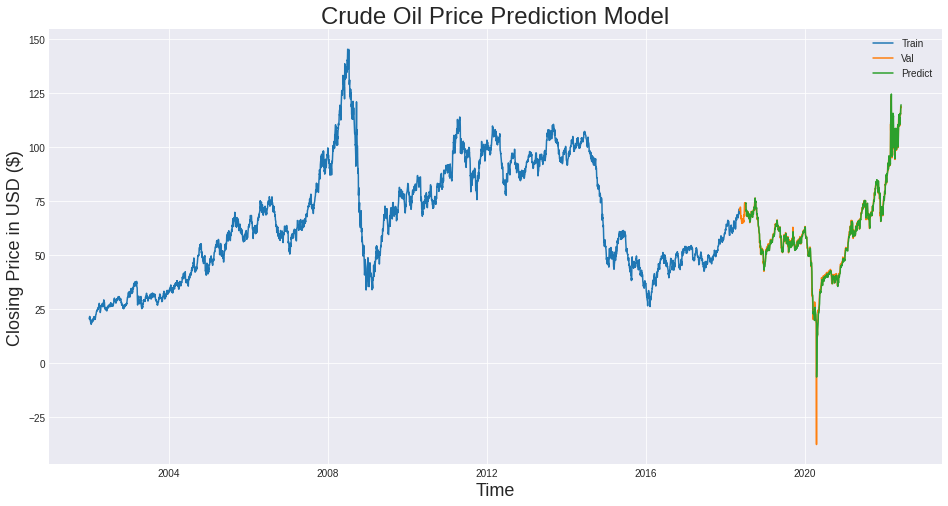

In [156]:
plt.figure(figsize=(16,8))
plt.title('Crude Oil Price Prediction Model', fontsize=24)
plt.xlabel('Time',fontsize=18)
plt.ylabel('Closing Price in USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predict'])
plt.show()

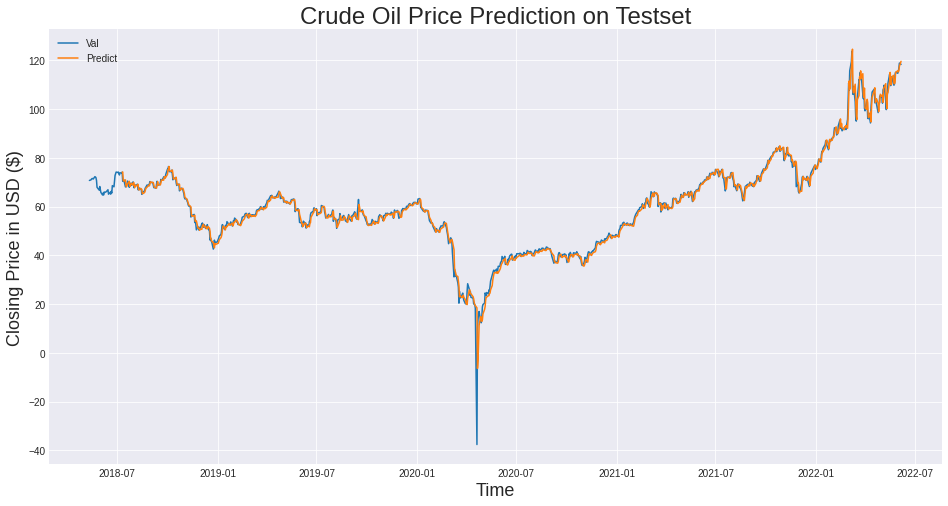

In [157]:
plt.figure(figsize=(16,8))
plt.title('Crude Oil Price Prediction on Testset', fontsize=24)
plt.xlabel('Time',fontsize=18)
plt.ylabel('Closing Price in USD ($)', fontsize=18)
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Val', 'Predict'])
plt.show()

* Memprediksi hari berikutnya dengan fitur sebanyak `n_days` data terakhir dan menggunakan model yang di training pada data train.

In [158]:
x_next_day = x_test[-1].reshape(1, n_days, 1)
next_day = model.predict(x_next_day)
# Unscalling
next_day = scaler.inverse_transform(next_day)

In [159]:
next_day[0,0]

119.57163

In [160]:
def predict_result(last_price_data, predict_price_data):

  last_price = last_price_data[-1, 0]
  next_price = predict_price_data[0,0]

  if last_price < next_price:
    print(f'Up --> {(next_price/last_price - 1)*100:.2f}%')
    print(f'Prediction Price : $ {next_price:.2f}')
  else:
    print(f'Down --> {(next_price/last_price - 1)*100:.2f}%')
    print(f'Prediction Price : $ {next_price:.2f}')

In [161]:
predict_result(dataset, next_day)

Up --> 1.07%
Prediction Price : $ 119.57


### Training All Data

In [162]:
scaler_all = MinMaxScaler()
scaled_data = scaler_all.fit_transform(dataset)

x = []
y = []

for i in range(n_days, len(scaled_data) - n_days):
  x.append(scaled_data[i-n_days:i, 0])
  y.append(scaled_data[i, 0])
	
#mengubah data menjadi format numpy array
x_train_all, y_train_all = np.array(x), np.array(y)

#mengubah dimensi data train menjadi 3 dimensi karena LSTM butuh data berdimensi 3
# [number of samples, number of time steps, and number of features]
x_train_all = np.reshape(x_train_all, (
    x_train_all.shape[0],
    x_train_all.shape[1],
    1
))

#Build Architecture for Neural Network
model_all = Sequential()
model_all.add(LSTM(50, return_sequences=True, input_shape=(x_train_all.shape[1], 1)))
model_all.add(LSTM(50, return_sequences=False))
model_all.add(Dense(units=25))
model_all.add(Dense(1))

#Compile the architecture
model_all.compile(optimizer='adam', loss='mean_squared_error')

callbacks_all = [
    EarlyStopping(monitor= 'loss', mode= 'min', patience=4, verbose=1),
    ModelCheckpoint('ts_all_crudeoil.hdf5', monitor='loss', save_best_only=True)
]

model_all_history = model_all.fit(
  x_train_all, 
  y_train_all, 
  batch_size=32, 
  callbacks=callbacks_all,
  epochs=100
)

Epoch 1/100
158/158 [==============================] - 11s 44ms/step - loss: 0.0087
Epoch 2/100
158/158 [==============================] - 7s 44ms/step - loss: 4.4204e-04
Epoch 3/100
158/158 [==============================] - 7s 45ms/step - loss: 4.1551e-04
Epoch 4/100
158/158 [==============================] - 7s 44ms/step - loss: 3.7918e-04
Epoch 5/100
158/158 [==============================] - 7s 44ms/step - loss: 3.4908e-04
Epoch 6/100
158/158 [==============================] - 7s 43ms/step - loss: 3.2982e-04
Epoch 7/100
158/158 [==============================] - 7s 44ms/step - loss: 2.9407e-04
Epoch 8/100
158/158 [==============================] - 7s 44ms/step - loss: 3.0810e-04
Epoch 9/100
158/158 [==============================] - 7s 44ms/step - loss: 2.9879e-04
Epoch 10/100
158/158 [==============================] - 7s 45ms/step - loss: 2.7284e-04
Epoch 11/100
158/158 [==============================] - 7s 46ms/step - loss: 2.6404e-04
Epoch 12/100
158/158 [======================

In [163]:
x_last = scaled_data[-n_days:, 0]

x_last

array([0.74289311, 0.72118962, 0.75568557, 0.77563965, 0.79040019,
       0.79728846, 0.76640063, 0.76743935, 0.7731249 , 0.76372187,
       0.74442383, 0.76169912, 0.76344851, 0.78170788, 0.77804509,
       0.78066916, 0.76558063, 0.7951017 , 0.79756182, 0.80581676,
       0.76929806, 0.75109341, 0.78362128, 0.78591736, 0.80975292,
       0.830035  , 0.82019466, 0.80483272, 0.81915594, 0.82473217,
       0.80865956, 0.80581676, 0.80887824, 0.82943364, 0.8347912 ,
       0.83260444, 0.83582991, 0.84463158, 0.85556532, 0.85250385])

In [164]:
pred_next_day = model_all.predict(x_last.reshape(1, n_days, 1))
pred_next_day_price = scaler_all.inverse_transform(pred_next_day)

In [165]:
predict_result(dataset, pred_next_day_price)

Up --> 1.11%
Prediction Price : $ 119.63


## ix. Model Saving

Model telah disave dengan menggunakan model checkpoint pada callback.

## x. Model Inference

Membuat data random yang nilainya sekitar `n_days` data terakhir dari dataset.

In [166]:
a = np.random.normal(1, 0.01, size=(n_days, 1))

x_inf = a*dataset[-n_days:]

Scalling data inference.

In [167]:
x_inf_scaled = scaler.transform(x_inf)

Load model.

In [168]:
best_model = load_model('ts_all_crudeoil.hdf5')

Prediksi data inference

In [169]:
pred_inf = best_model.predict(x_inf_scaled.reshape(1, n_days, 1))
pred_inf_price = scaler.inverse_transform(pred_inf)

In [170]:
predict_result(x_inf, pred_inf_price)

Up --> 1.22%
Prediction Price : $ 120.06


## xi. Pengambilan Kesimpulan

1. Dataset yang digunakan adalah data dari Yahoo Finance.
3. Dataset dibagi menjadi 2 bagian yaitu: 
    - Trainset  : 4108 data (80%)
    - Valset/Testset    : 1026 data (20%)
4. Jumlah fitur yang digunakan adalah 40 data.

6. Arsitektur neural network yang dibangun adalah sebagai berikut:
    - Model sequential.
    - Terdapat 2 layer LSTM dengan jumlah masing-masing 50 neuron.
    - Terdapat 1 hidden layer dengan 25 neuron.
    - Terdapat 1 neuron output.
    - Model dicompile dengan optimizer adam dan loss mean squared error.
    
8. Model terbaik yang didapatkan menghasilkan loss sebesar 1.8875e-04 dan validasi loss sebesar 4.4230e-04 dengan nilai Root Mean Square Error pada testset adalah $2.70.